In [1]:
# Author: Fengli Lin && Yutong Zhai
# Date: 13/04/2019
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage, misc
import pdb
import cv2
import imageio
import scipy.signal as sig
import os
import glob
%matplotlib inline

In [2]:
def grayScale(color_img):
    """ Function to return a grayscale version of an image"""
    return np.dot(color_img[..., :3], [0.299, 0.587, 0.114])


def contrast(img):
    """function to calculate the contrast of an image"""
    grey = grayScale(img)
    return np.abs(ndimage.filters.laplace(grey))


def saturation(img):
    """function to calculate the saturation of an image"""
    red_canal = img[:, :, 0]
    green_canal = img[:, :, 1]
    blue_canal = img[:, :, 2]

    mean = (red_canal + green_canal + blue_canal) / 3.0
    satu = np.sqrt(((red_canal - mean) ** 2
                    + (green_canal - mean) ** 2
                    + (blue_canal - mean) ** 2) / 3.0)
    return satu


def exponential_euclidean(canal, sigma):
    return np.exp(-(canal - 0.5)**2 / (2 * sigma**2))


def exposedness(img, sigma):
    """function to calculate well-exposedness of an image"""
    red_canal = img[:, :, 0]
    green_canal = img[:, :, 1]
    blue_canal = img[:, :, 2]

    red_exp = exponential_euclidean(red_canal, sigma)
    green_exp = exponential_euclidean(green_canal, sigma)
    blue_exp = exponential_euclidean(blue_canal, sigma)

    return red_exp * green_exp * blue_exp


def weight_map(img, w_c, w_s, w_e, sigma, eplison):
    weight = []
    sums = np.zeros((img.shape[0], img.shape[1]))
    cont = contrast(img)

    satu = saturation(img)

    expose = exposedness(img, sigma)
    
    print(cont.min())
    print(satu.min())
    print(expose.min())
    C = 1
    
    weight = (cont ** w_c+ C) * (satu ** w_s+ C) * (expose ** w_e+ C)+eplison

    return weight

In [3]:
# Compute naive fusion image

path = "./dataset/ex1/"
img = []
for filename in glob.glob(os.path.join(path, '*.jpg')):
    print(filename)
    tmp = mpimg.imread(filename)/255
    # input image shape need to be exact divided by 16
    if(tmp.shape[1]%16 != 0 or tmp.shape[0]%16 != 0):
        tmp = cv2.resize(tmp,(int(tmp.shape[1]/16)*16,int(tmp.shape[0]/16)*16))
    img.append(tmp)

weight_img = []
for i in img:
    weight_img.append(weight_map(i, 1, 1, 1, 0.2, 1e-12))


weight_all = np.sum(weight_img, axis=0)

norm_weight_img = []
for i in weight_img:
    norm_weight_img.append(i / weight_all)

navie_img = []
for i in range(len(img)):
    tmp = np.zeros(img[0].shape)
    for canal in range(3):
        tmp[:, :, canal] = norm_weight_img[i] * img[i][:, :, canal]
    navie_img.append(tmp)

navie_fusion = np.sum(navie_img, axis=0)
norm_naive = cv2.normalize(navie_fusion, None, alpha=0,
                           beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

./dataset/ex1/mask_over.jpg
./dataset/ex1/mask_under.jpg
./dataset/ex1/mask_mean.jpg
0.0
0.0
8.481823524646926e-05
0.0
0.0
8.481823524646926e-05
0.0
0.0
8.481823524646926e-05


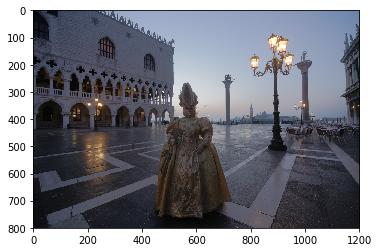

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [4]:
plt.imshow(norm_naive)
plt.show()
imageio.imwrite('Naive_fusion_img.jpg',norm_naive)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


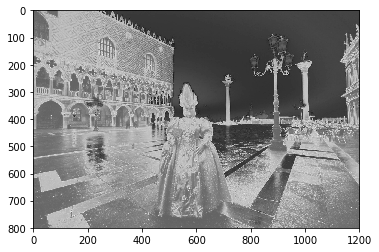

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


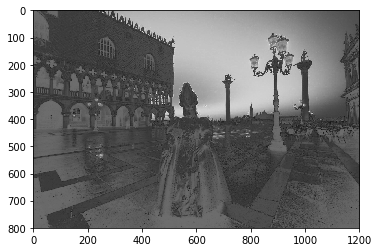

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


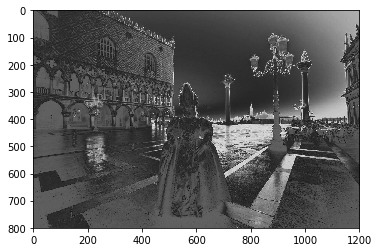

In [5]:
for i in range(len(img)):
    imageio.imwrite('norm_weight_img%d.jpg'%i, norm_weight_img[i])
    plt.imshow(norm_weight_img[i], cmap='gray')
    plt.show()

In [6]:
def get_kernel():
    kernel_1D = [0.05, 0.25, 0.4, 0.25, 0.05]
    kernel = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            kernel[i, j] = kernel_1D[i]*kernel_1D[j]
    return kernel


def Reduce1(image):
    kernel = get_kernel()
    shape = image.shape
    if len(shape) == 3:
        image_reduced = np.zeros((int(shape[0]/2), int(shape[1]/2), 3))
        for canal in range(3):
            canal_reduced = sig.convolve2d(
                image[:, :, canal], kernel, 'same', boundary='symm')
            image_reduced[:, :, canal] = canal_reduced[::2, ::2]
    else:
        image_reduced = sig.convolve2d(
            image, kernel, 'same', boundary='symm')[::2, ::2]
    return image_reduced


def Expand1(image):
    kernel = get_kernel()
    shape = image.shape
    if len(shape) == 3:
        image_to_expand = np.zeros((2*shape[0], 2*shape[1], 3))
        image_expanded = np.zeros(image_to_expand.shape)
        for canal in range(3):
            image_to_expand[::2, ::2, canal] = image[:, :, canal]
            image_expanded[:, :, canal] = sig.convolve2d(
                image_to_expand[:, :, canal], 4*kernel, 'same')
    else:
        image_to_expand = np.zeros((2 * shape[0], 2 * shape[1]))
        image_to_expand[::2, ::2] = image
        image_expanded = sig.convolve2d(
            image_to_expand[:, :], 4*kernel, 'same', boundary='symm')
    return image_expanded

In [7]:
def Gaussian_Pyramid(img, level=4):
    # Gaussian Pyramid
    layer = img.copy()
    gaussian_pyramid = [layer]
    for i in range(level):
        layer = Reduce1(layer)
        gaussian_pyramid.append(layer)
    return gaussian_pyramid


def Laplacian_Pyramid(img, level=4):
    gaussian_pyramid = Gaussian_Pyramid(img, level)
    # Laplacian Pyramid
    layer = gaussian_pyramid[level-1]
    laplacian_pyramid = [layer]
    for i in range(level-1, 0, -1):
        size = (gaussian_pyramid[i - 1].shape[1],
                gaussian_pyramid[i - 1].shape[0])
        gaussian_expanded = Expand1(gaussian_pyramid[i])
        laplacian = gaussian_pyramid[i - 1] - gaussian_expanded
        laplacian_pyramid.append(laplacian)
    return laplacian_pyramid


def Reconstruct_Laplacian_Pyramid(laplacian_pyramid, level=4):
    # Reconstructed Laplacian Pyramid
    reconstructed = laplacian_pyramid[0]
    for i in range(1, level):
        reconstructed = Expand1(reconstructed)
        reconstructed = cv2.add(laplacian_pyramid[i], reconstructed)
    return reconstructed

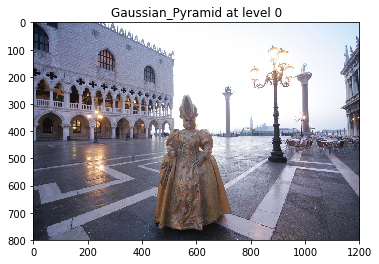

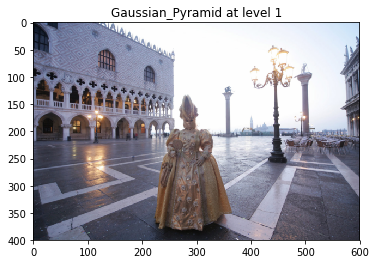

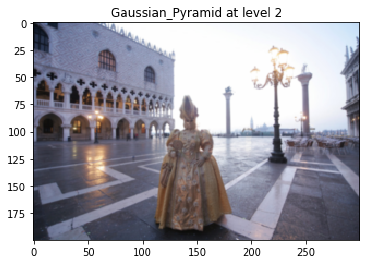

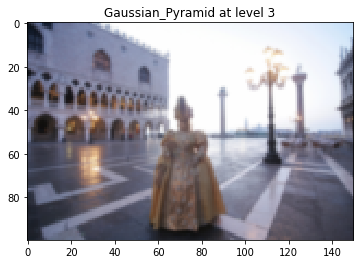

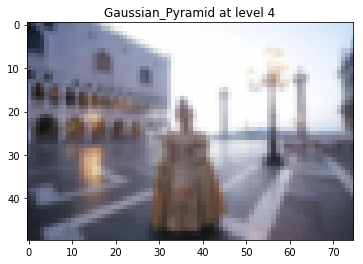

In [8]:
def test_Gaussian_pyramid():
    tmp = Gaussian_Pyramid(img[0])
    for i in range(len(tmp)):
        plt.imshow(tmp[i])
        plt.title("Gaussian_Pyramid at level %d" % i)
        plt.show()
test_Gaussian_pyramid()

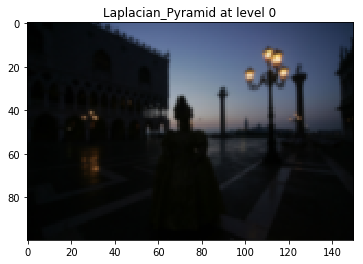

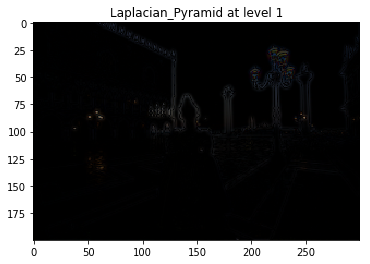

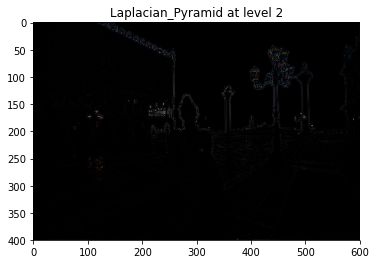

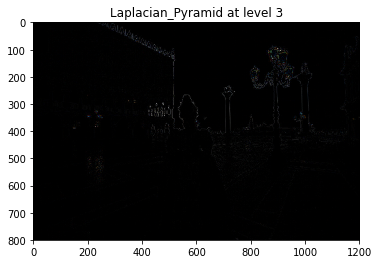

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


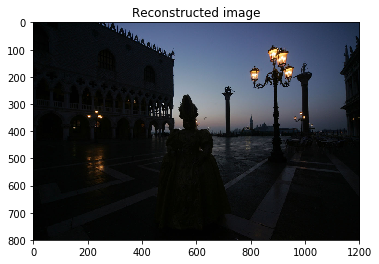

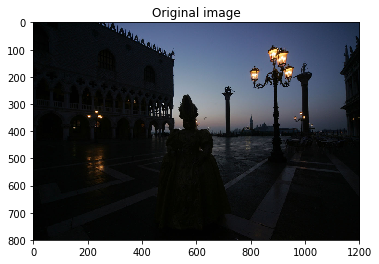

In [9]:
def test_Laplacian_pyramid():
    img_test = img[1]
    tmp = Laplacian_Pyramid(img_test)
    for i in range(len(tmp)):
        plt.imshow(np.abs(tmp[i]))
        plt.title("Laplacian_Pyramid at level %d"%i)
        plt.show()
    re = Reconstruct_Laplacian_Pyramid(tmp)
    plt.imshow(re)
    plt.title("Reconstructed image")
    plt.show()
    plt.imshow(img_test)
    plt.title("Original image")
    plt.show()
test_Laplacian_pyramid()

In [10]:
# Exposure fusion

level = 4
weight_pyramid = []
for i in norm_weight_img:
    weight_pyramid.append(Gaussian_Pyramid(i, level))
laplacian_pyramid_img = []
for i in img:
    laplacian_pyramid_img.append(Laplacian_Pyramid(i, level))

pyramid_img = []    
for i in range(len(img)):
    tmp = Laplacian_Pyramid(np.zeros(img[i].shape), level)
    for j in range(len(tmp)):
        for canal in range(3):
            tmp[-1-j][:, :, canal] += weight_pyramid[i][j] * \
                laplacian_pyramid_img[i][-1-j][:, :, canal]
    pyramid_img.append(tmp)

pyramid_fusion = np.sum(pyramid_img,axis=0)
res = Reconstruct_Laplacian_Pyramid(pyramid_fusion, level)

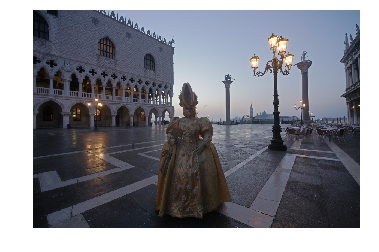

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [11]:
res[res < 0] = 0
res[res > 1] = 1
plt.imshow(res)
plt.axis('off')
plt.show()
imageio.imwrite('Fusion_img.jpg', res)